In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
import cv2

In [ ]:
X_images = np.load('X.npy')
y_images = np.load('Y.npy')   

# shuffle data
perm_array = np.arange(len(X_images))
np.random.shuffle(perm_array)
X_images = X_images[perm_array]
y_images = y_images[perm_array]

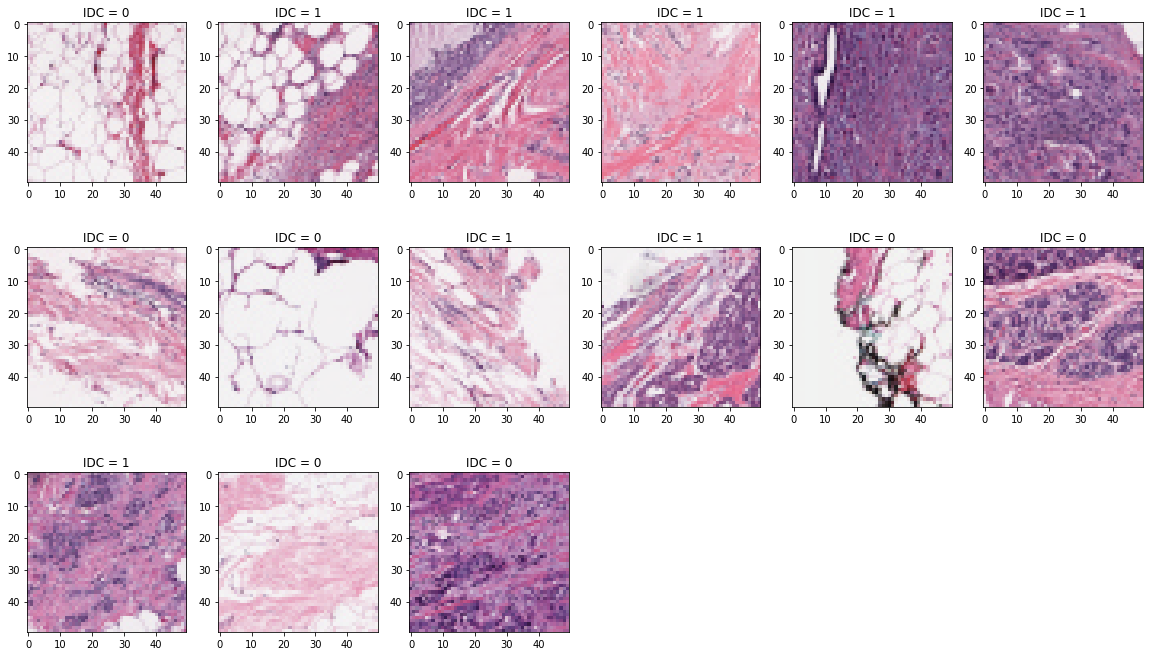

In [ ]:
imgs_0 = X_images[y_images == 0] # 0 = no cancer
imgs_1 = X_images[y_images == 1] # 1 = cancer

plt.figure(figsize=(20,20))
for i in range(15):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%y_images[i])
    plt.imshow(X_images[i])

In [ ]:
def one_hot_to_dense(labels_one_hot):
    return np.argmax(labels_one_hot,1)

def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


def normalize_data(data): 
    data = data / data.max() 
    return data

X = normalize_data(X_images)


In [ ]:
from keras.applications.vgg19 import VGG19

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_images, test_size=0.2, random_state=42)

In [ ]:
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]
X_train.shape

(4437, 50, 50, 3)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

input_shape = X_train.shape[1:]

In [ ]:
def resize_img(img):
    numberOfImage = img.shape[0]
    new_array = np.zeros((numberOfImage, 64,64,3))
    for i in range(numberOfImage):
        new_array[i] = cv2.resize(img[i,:,:,:],(64,64))
    return new_array

X_train = resize_img(X_train)
X_test = resize_img(X_test)
print("increased dim x_train: ",X_train.shape)

increased dim x_train:  (4437, 64, 64, 3)


In [ ]:
vgg = VGG19(include_top = False, weights = "imagenet", input_shape = (64,64,3))

print(vgg.summary())

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
model = tf.keras.Sequential()
for layer in vgg.layers:
    model.add(layer)
    
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)      

In [ ]:
for layer in model.layers:
    layer.trainable = False

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.Dense(2, activation= "sigmoid"))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 16, 16, 256)      

In [ ]:
model.compile(loss = "binary_crossentropy",
              optimizer = "rmsprop",
              metrics = ["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, validation_split = 0.3, epochs = 100, batch_size = 1000)

Epoch 1/100
4/4 [==============================] - 47s 5s/step - loss: 2.4870 - accuracy: 0.5098 - val_loss: 0.8543 - val_accuracy: 0.5225
Epoch 2/100
4/4 [==============================] - 4s 920ms/step - loss: 0.7519 - accuracy: 0.5807 - val_loss: 0.7597 - val_accuracy: 0.5180
Epoch 3/100
4/4 [==============================] - 4s 914ms/step - loss: 0.8698 - accuracy: 0.5150 - val_loss: 0.6663 - val_accuracy: 0.6584
Epoch 4/100
4/4 [==============================] - 4s 914ms/step - loss: 0.6665 - accuracy: 0.6731 - val_loss: 0.7429 - val_accuracy: 0.6524
Epoch 5/100
4/4 [==============================] - 4s 913ms/step - loss: 0.6893 - accuracy: 0.6783 - val_loss: 0.6431 - val_accuracy: 0.6404
Epoch 6/100
4/4 [==============================] - 4s 908ms/step - loss: 0.6638 - accuracy: 0.6222 - val_loss: 0.7892 - val_accuracy: 0.5548
Epoch 7/100
4/4 [==============================] - 4s 914ms/step - loss: 0.6999 - accuracy: 0.5855 - val_loss: 0.6428 - val_accuracy: 0.6502
Epoch 8/100
4/4

In [ ]:
model.evaluate(X_test, y_test)

35/35 [==============================] - 4s 68ms/step - loss: 0.5678 - accuracy: 0.7270


[0.567829966545105, 0.7270269989967346]

Text(0.5, 0, 'Epochs')

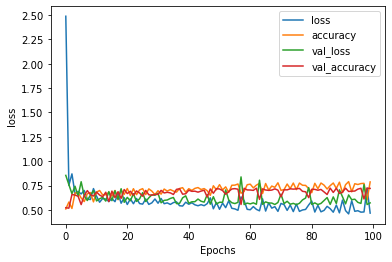

In [ ]:
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("Epochs")